In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.special import softmax
from deap import base, creator, tools, algorithms
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# --- Stock universe ---
stock_symbols = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}

# --- Fetch historical stock data with indicators ---
def get_stock_data(symbol):
    stock = yf.Ticker(symbol)
    df = stock.history(period="1y")["Close"].to_frame()
    if df.empty or len(df) < 250:
        return pd.DataFrame()
    df.columns = ["Close"]
    df["SMA_12"] = df["Close"].rolling(window=12).mean()
    df["SMA_26"] = df["Close"].rolling(window=26).mean()
    df["RSI"] = 100 - (100 / (1 + df["Close"].pct_change().rolling(14).mean() /
                                  df["Close"].pct_change().rolling(14).std()))
    df["BB_Upper"] = df["Close"].rolling(window=20).mean() + 2 * df["Close"].rolling(window=20).std()
    df["BB_Lower"] = df["Close"].rolling(window=20).mean() - 2 * df["Close"].rolling(window=20).std()
    df["Returns"] = df["Close"].pct_change()
    df.dropna(inplace=True)
    return df

# --- Compute dynamic trend-based scores ---
def compute_dynamic_scores(stock_data):
    scores = {}
    reasons = {}
    for symbol, df in stock_data.items():
        volatility = df["Returns"].std()
        volatility = volatility if not np.isnan(volatility) and volatility > 0 else 1e-6
        volatility_penalty = np.exp(-5 * volatility)

        slope = 0
        if len(df) >= 60:
            y = df["Close"].values[-60:]
            x = np.arange(len(y))
            slope = np.polyfit(x, y, 1)[0]

        peaks = df[df["Close"] == df["Close"].rolling(15, center=True).max()]
        troughs = df[df["Close"] == df["Close"].rolling(15, center=True).min()]
        total_peak_score = sum(np.exp(-(len(df) - i) / 100) for i in peaks.index.astype(int))
        total_trough_score = sum(np.exp(-(len(df) - i) / 100) for i in troughs.index.astype(int))

        total_score = (total_peak_score + total_trough_score) * (1 + slope) * volatility_penalty
        scores[symbol] = total_score
        reasons[symbol] = f"Peaks: {len(peaks)}, Troughs: {len(troughs)}, Volatility: {volatility:.4f}, Slope: {slope:.4f}"

    return scores, reasons

# --- Normalize with softmax, ensure no negatives ---
def normalize_scores_to_weights(scores, commission=0.001):
    scores_arr = np.nan_to_num(np.array(list(scores.values())), nan=0.0, posinf=0.0, neginf=0.0)
    score_weights = softmax(scores_arr)
    adjusted_weights = {}
    for (symbol, _), soft in zip(scores.items(), score_weights):
        adjusted = max(soft - commission, 0)
        adjusted_weights[symbol] = adjusted
    total = sum(adjusted_weights.values())
    if total == 0:
        return {k: 1 / len(scores) for k in scores}
    return {k: v / total for k, v in adjusted_weights.items()}

# --- Fetch fundamental metrics ---
def fetch_fundamentals(symbols):
    fundamentals = {}
    for symbol in symbols:
        try:
            stock = yf.Ticker(symbol)
            info = stock.info
            pe = info.get("trailingPE")
            risk = info.get("beta")
            growth = info.get("earningsGrowth")
            health = info.get("returnOnEquity")
            if None in (pe, risk, growth, health):
                continue
            fundamentals[symbol] = {
                "PE": pe,
                "Risk": risk,
                "Growth": growth,
                "Health": health
            }
        except Exception as e:
            print(f"Skipping {symbol}: {e}")
    return fundamentals

# --- PDF Report Generator ---
def generate_pdf_report(data, reasons, filename="portfolio_report.pdf"):
    c = canvas.Canvas(filename, pagesize=letter)
    width, height = letter
    c.setFont("Helvetica", 12)
    c.drawString(30, height - 40, "Final Portfolio Allocation Report")
    c.setFont("Helvetica", 10)
    y = height - 70
    for _, row in data.iterrows():
        symbol = row["Stock"]
        weight = row["Final_Allocation"]
        reason = reasons.get(symbol, "")
        c.drawString(30, y, f"{stock_symbols[symbol]} ({symbol}) - Allocation: {weight:.4f}")
        y -= 15
        if reason:
            c.setFont("Helvetica-Oblique", 9)
            c.drawString(40, y, f"Reason: {reason}")
            c.setFont("Helvetica", 10)
            y -= 20
        if y < 100:
            c.showPage()
            y = height - 50
    c.save()

# --- Main Pipeline ---
if __name__ == "__main__":
    # 1. Load stock data
    all_stock_data = {}
    for symbol in stock_symbols:
        data = get_stock_data(symbol)
        if not data.empty:
            all_stock_data[symbol] = data

    # 2. Compute technical trend scores
    dynamic_scores, reasons = compute_dynamic_scores(all_stock_data)
    trend_weights = normalize_scores_to_weights(dynamic_scores)

    # 3. Fetch and prepare fundamentals
    fundamentals = fetch_fundamentals(all_stock_data.keys())
    fundamental_rows = []
    for symbol in fundamentals:
        row = {"Stock": symbol}
        row.update(fundamentals[symbol])
        fundamental_rows.append(row)
    fundamental_df = pd.DataFrame(fundamental_rows)

    # 4. Optimize with GA
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def calculate_scores(df, weights):
        df = df.copy()
        df["Score"] = (
            weights["PE"] * (1 / df["PE"]) +
            weights["Risk"] * (1 / df["Risk"]) +
            weights["Growth"] * df["Growth"] +
            weights["Health"] * df["Health"]
        )
        df["Normalized_Score"] = df["Score"] / df["Score"].sum()
        return df

    def evaluate(ind):
        weights = {"PE": ind[0], "Risk": -ind[1], "Growth": ind[2], "Health": ind[3]}
        scored_df = calculate_scores(fundamental_df, weights)
        return scored_df["Normalized_Score"].sum(),

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=50)
    for _ in range(10):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        fits = list(map(toolbox.evaluate, offspring))
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))

    top_ind = tools.selBest(population, k=1)[0]
    optimized_weights = {"PE": top_ind[0], "Risk": -top_ind[1], "Growth": top_ind[2], "Health": top_ind[3]}
    scored_df = calculate_scores(fundamental_df, optimized_weights)

    # 5. Combine fundamental and trend scores
    combined_df = scored_df.copy()
    combined_df["Trend_Weight"] = combined_df["Stock"].map(trend_weights)
    combined_df["Final_Allocation"] = 0.3 * combined_df["Normalized_Score"] + 0.7 * combined_df["Trend_Weight"]
    combined_df["Final_Allocation"] = combined_df["Final_Allocation"].clip(lower=0)
    combined_df["Final_Allocation"] = combined_df["Final_Allocation"] / combined_df["Final_Allocation"].sum()

    print("\nFinal Combined Optimized Portfolio Allocation:")
    print(combined_df[["Stock", "Final_Allocation"]])
    combined_df.to_csv("final_combined_portfolio.csv", index=False)

    # 6. Plot and Save
    for symbol in combined_df["Stock"]:
        df = all_stock_data[symbol]
        plt.figure(figsize=(10, 5))
        plt.plot(df["Close"], label="Close")
        plt.plot(df["SMA_12"], label="SMA 12")
        plt.plot(df["SMA_26"], label="SMA 26")
        plt.title(f"{stock_symbols[symbol]} ({symbol})\n{reasons.get(symbol, '')}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plot_{symbol}.png")
        plt.close()
    print("\nSaved final allocation and trend plots.")

    # 7. PDF Report
    generate_pdf_report(combined_df, reasons)
    print("\nPDF report generated as 'portfolio_report.pdf'")


/tmp/ipykernel_94183/1392921488.py:54: RuntimeWarning: overflow encountered in exp
  total_peak_score = sum(np.exp(-(len(df) - i) / 100) for i in peaks.index.astype(int))
/tmp/ipykernel_94183/1392921488.py:55: RuntimeWarning: overflow encountered in exp
  total_trough_score = sum(np.exp(-(len(df) - i) / 100) for i in troughs.index.astype(int))
/tmp/ipykernel_94183/1392921488.py:54: RuntimeWarning: overflow encountered in exp
  total_peak_score = sum(np.exp(-(len(df) - i) / 100) for i in peaks.index.astype(int))
/tmp/ipykernel_94183/1392921488.py:55: RuntimeWarning: overflow encountered in exp
  total_trough_score = sum(np.exp(-(len(df) - i) / 100) for i in troughs.index.astype(int))
/tmp/ipykernel_94183/1392921488.py:54: RuntimeWarning: overflow encountered in exp
  total_peak_score = sum(np.exp(-(len(df) - i) / 100) for i in peaks.index.astype(int))
/tmp/ipykernel_94183/1392921488.py:55: RuntimeWarning: overflow encountered in exp
  total_trough_score = sum(np.exp(-(len(df) - i) / 100


Final Combined Optimized Portfolio Allocation:
     Stock  Final_Allocation
0   U11.SI          0.091652
1  C38U.SI          0.086771
2   Q0F.SI          0.310716
3   S68.SI          0.418676
4   S63.SI          0.092185
5  AJBU.SI          0.000000

Saved final allocation and trend plots.

PDF report generated as 'portfolio_report.pdf'


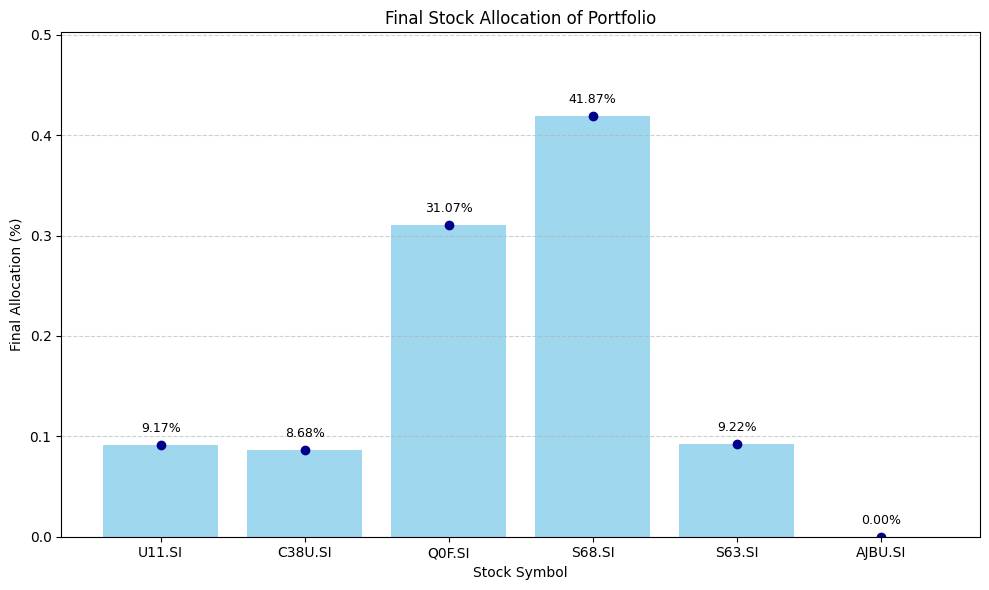

In [22]:
# 8. Bar Plot with Allocation Markers
plt.figure(figsize=(10, 6))
bars = plt.bar(combined_df["Stock"], combined_df["Final_Allocation"], color='skyblue', alpha=0.8)

# Add markers above each bar
for bar in bars:
    height = bar.get_height()
    plt.plot(bar.get_x() + bar.get_width()/2, height, 'o', color='darkblue')
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.2%}", ha='center', va='bottom', fontsize=9)

plt.title("Final Stock Allocation of Portfolio")
plt.xlabel("Stock Symbol")
plt.ylabel("Final Allocation (%)")
plt.ylim(0, max(combined_df["Final_Allocation"]) * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("final_allocation_bar_plot.png")
plt.show()


In [23]:
import matplotlib.pyplot as plt

def plot_sma_trend_signal(symbol, name, df):
    plt.figure(figsize=(14, 6))

    # Plot price and moving averages
    plt.plot(df.index, df["Close"], label="Close Price", color="black", linewidth=1.2)
    plt.plot(df.index, df["SMA_12"], label="SMA 12", color="blue", linestyle="--")
    plt.plot(df.index, df["SMA_26"], label="SMA 26", color="orange", linestyle="-")

    # Detect and mark golden cross / death cross
    crossover = (df["SMA_12"] > df["SMA_26"]).astype(int).diff()
    golden_cross = df[crossover == 1].index
    death_cross = df[crossover == -1].index

    for date in golden_cross:
        plt.axvline(date, color="green", linestyle="--", alpha=0.5, label="Golden Cross")
    for date in death_cross:
        plt.axvline(date, color="red", linestyle="--", alpha=0.5, label="Death Cross")

    # Peaks and troughs
    peaks = df[df["Close"] == df["Close"].rolling(15, center=True).max()]
    troughs = df[df["Close"] == df["Close"].rolling(15, center=True).min()]
    plt.scatter(peaks.index, peaks["Close"], label="Peaks", color="limegreen", marker="^", s=30)
    plt.scatter(troughs.index, troughs["Close"], label="Troughs", color="crimson", marker="v", s=30)

    plt.title(f"{name} ({symbol}) - Trend & Crossover Signals")
    plt.xlabel("Date")
    plt.ylabel("Price (SGD)")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"chart_{symbol}_trend_signals.png")
    plt.show()


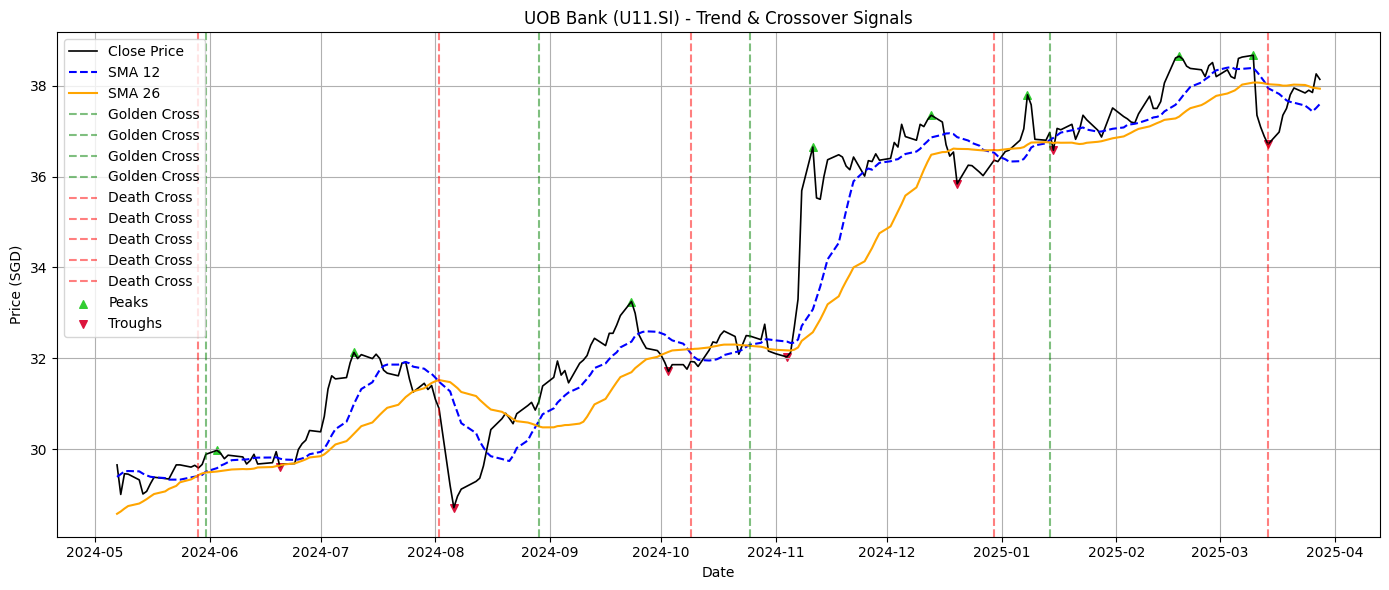

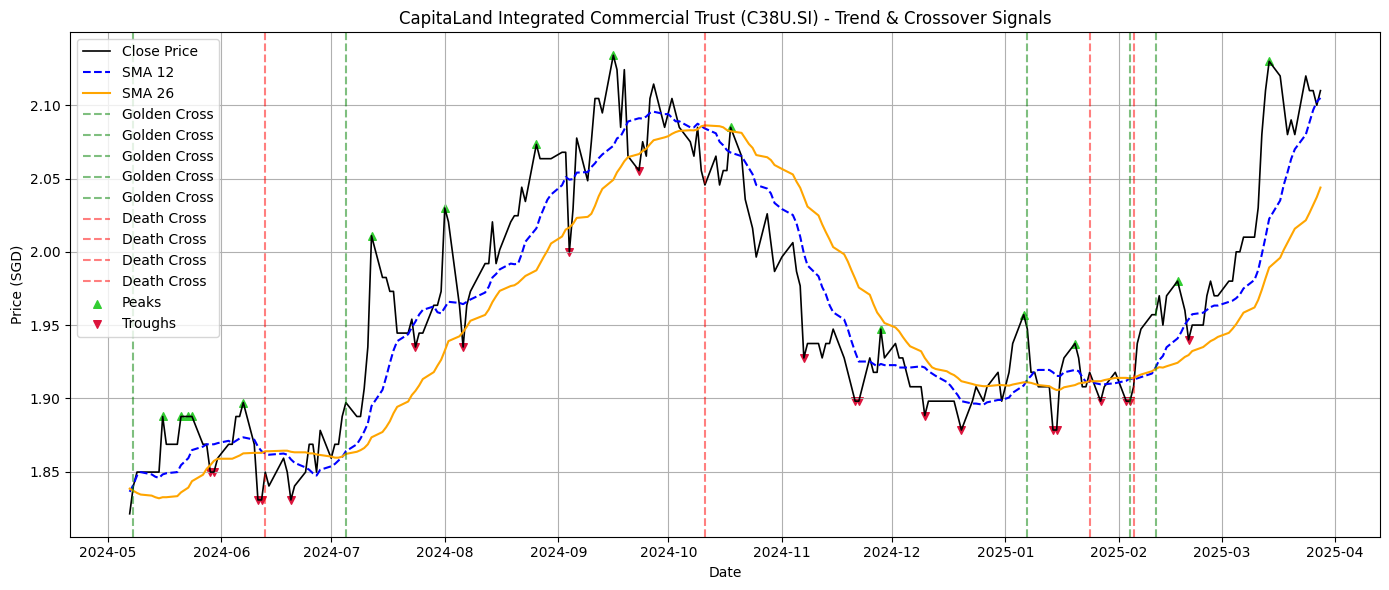

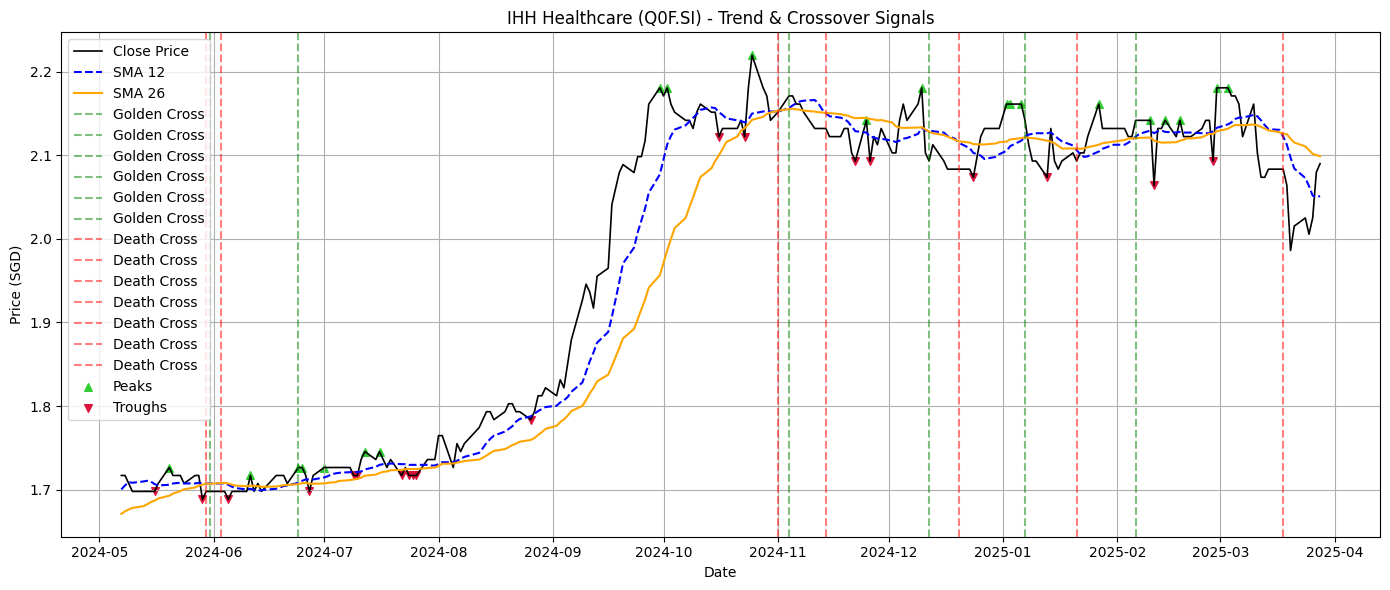

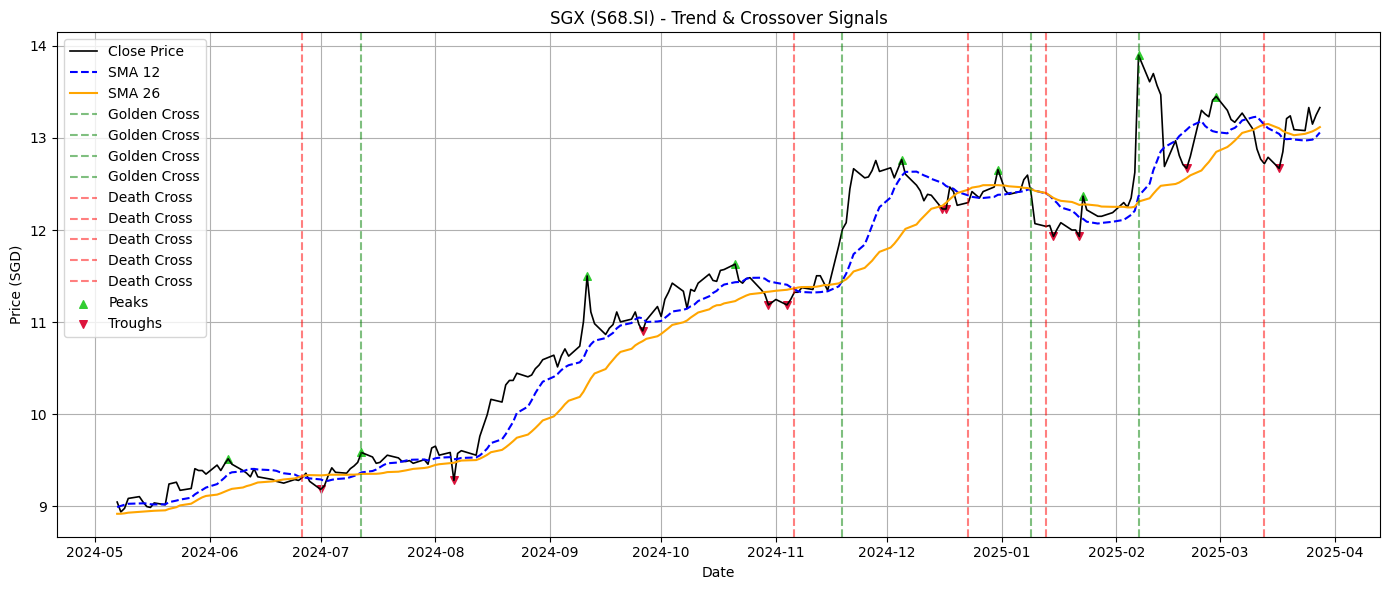

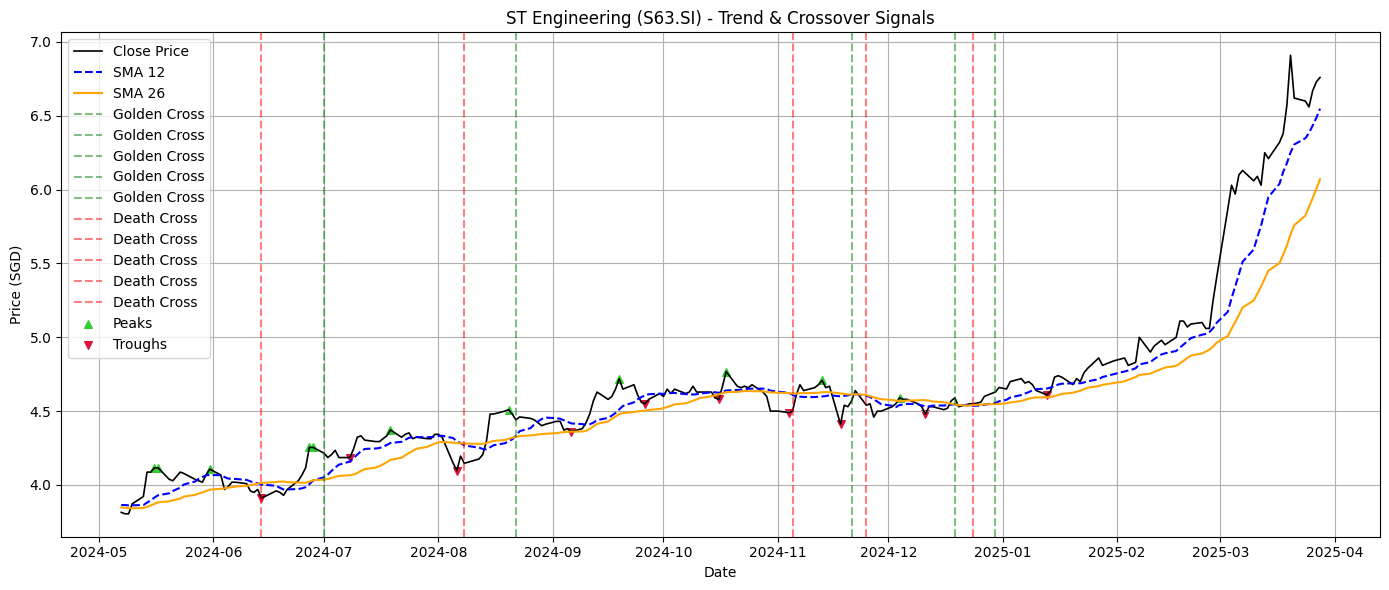

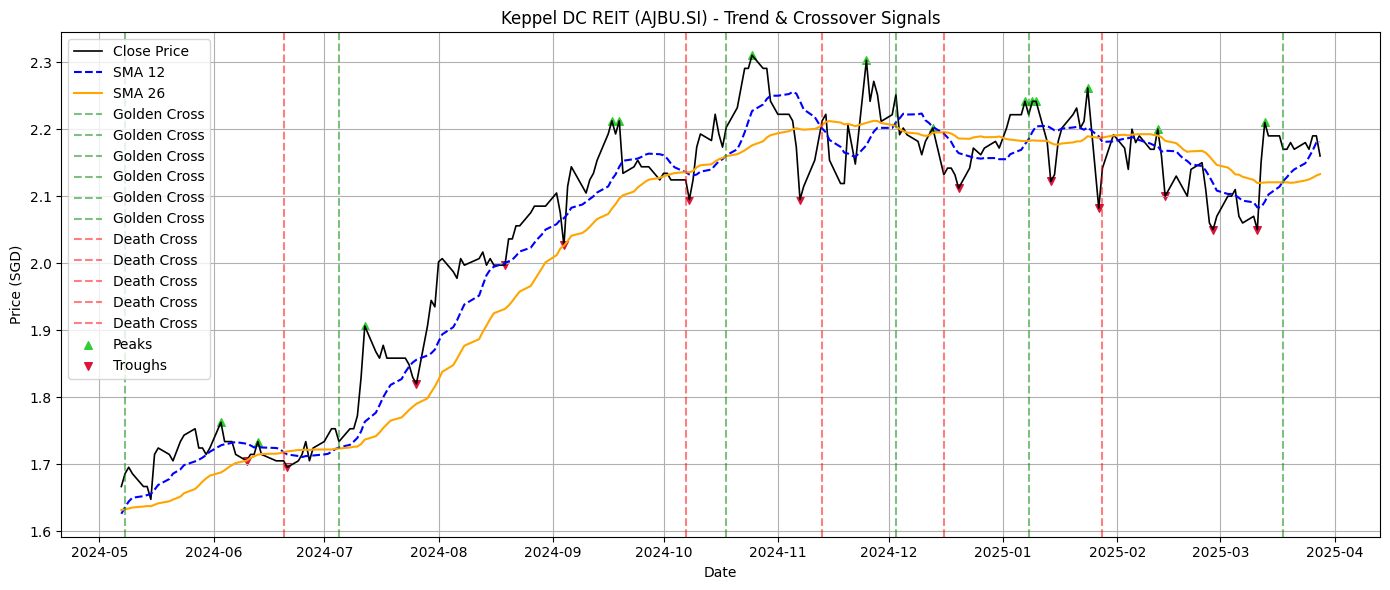

In [24]:
for symbol in combined_df["Stock"]:
    df = all_stock_data[symbol]
    plot_sma_trend_signal(symbol, stock_symbols[symbol], df)


stock_symbols = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": " ST Engineering",
    "AJBU.SI": " Keppel DC REIT"

}
